In [53]:
from astropy.table import Table, Column
import time
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import sys
from scipy.stats import kde
from tqdm import tqdm          
sys.path.insert(0, '../Modules')
import erqMedSpec 
import erqScaling
from line_db import line_db
import os
from scipy import interpolate
# Reading data
# smp=Table.read('/home/reza/erq/sampling/org_sample2.fits')
smp=Table.read('../LumMatch/LumMatch.fits')
W3_0=smp['ABw3']
iW3_0 = smp['i-w3']
kt80_0= smp['kurt80_gf']
rew_0 = smp['rew_gf']
rew_0  = np.log10(rew_0)
frat_0 = smp['frat_nv/civ']
fwhm_0 = smp['fwhm_gf']
z_dr12=smp['z_dr12']
plate = smp['Plate']
mjd = smp['MJD']
fiberid= smp['FiberID']
iz_0 = iW3_0 - smp['r-w3'] + smp['r-z']
Lum_0 = smp['Lum']
# iz_0 = smp['i-z']
print(min(iW3_0), max(iW3_0))
3

0.8008424710000028 8.014450848000003


3

In [2]:
def DensityBinner_3d(sample,  ERQ, bw, rhoBin, opening_angle, coneVector):
        """ Sample -> scaled sample
                sample_direction-> angels of all sample points from ERQ vector
        """

        from scipy.stats   import gaussian_kde
        import numpy as np
        dimSample = np.size(sample, axis=1)
        nSample=len(sample)
        MainCenter = np.median(sample, axis=0)
        nBin = len(rhoBin)
        bin_label=np.zeros(nSample)
        bin_pop=np.zeros(nBin)
        tip_label=np.zeros(nSample)
        r=np.zeros(nSample) # distance from MainCenter
        MedianBins=np.zeros([nBin, dimSample+1])
        sample_direction = erqMedSpec.separation(sample-MainCenter, coneVector)

        values = sample.T
        kde = gaussian_kde(values)
        kde.set_bandwidth(bw_method=kde.factor*bw)
        density = kde(values)
        density_max = max(density)
        density/=density_max


        nBin = np.size(rhoBin)
#     tip-label
        for i in range(nSample):
            if density[i] >= rhoBin[1]:
                tip_label[i]=1

        for k in range(nBin):
            for i in range(nSample):
                if (np.arccos(sample_direction[i])<=opening_angle):
                    if(k<nBin-1):
                        if((density[i] <= rhoBin[k]) and (density[i] >= rhoBin[k+1])):
                            bin_label[i] = k+1
                            bin_pop[k]+=1
                    else:
                        if(density[i] <= rhoBin[k]):
                            bin_label[i]=nBin
                            bin_pop[nBin-1]+=1

        return bin_label, bin_pop, tip_label, MedianBins, rhoBin

def uniter(sampleVector):
        """
        gets a bunch of vectors gives unit vectors
        """
        sampleVector_unit = np.zeros(np.shape(sampleVector))
        L = np.linalg.norm(sampleVector,axis=1)
        for i in range(len(sampleVector)):
                sampleVector_unit[i,:] = sampleVector[i,:]/L[i]
        return sampleVector_unit


def opening_angle_finder(ERQ, Main_center,  enclosing_ratio, resolution):
        import numpy as np
        from scipy.stats import cumfreq
        import erqMedSpec
        ERQ_center = np.median(ERQ, axis=0)
        ERQ_vector = np.array(ERQ_center) - Main_center
        ERQ_vector_unit =  erqMedSpec.vectors_uniter(ERQ_vector)
        ERQ = ERQ - Main_center
        ERQ_unit = erqMedSpec.vectors_uniter(ERQ)

        wedge_direction = erqMedSpec.modified_arctan(ERQ_vector[0], ERQ_vector[1])
        ERQ_angles=[]
        for i in range(len(ERQ)):
                ERQ_angles.append(np.arccos(np.dot(ERQ_vector_unit, ERQ_unit[i,:])))



        res = cumfreq(ERQ_angles, numbins=resolution)
        x = res.lowerlimit + np.linspace(0, res.binsize*res.cumcount.size,
                                        res.cumcount.size)
        count = res.cumcount
        # return np.rad2deg(np.arccos(x[np.where(count==int(enclosing_ratio*len(ERQ_dir)))]))
        angle = x[np.where(count>=int(enclosing_ratio*len(ERQ_angles)))]
        return angle[0], wedge_direction



In [3]:
# ############################################################################

# Sample reading 
ERQ_rew = 2#(2 - min(rew_0))/(max(rew_0)-min(rew_0))
ERQ_color = 4.6#(4.6 - min(iW3_0))/(max(iW3_0)-min(iW3_0))
X=np.array(list(zip(iW3_0, rew_0, kt80_0)))
X_sc, minData, rangeData = erqScaling.MinMaxScaler(X)
mask = ((iW3_0>=4.6) & (rew_0>=2))
ERQ= X_sc[mask]
ERQ0= X[mask]


In [4]:
ERQCenter = np.median(ERQ, axis=0)
MainCenter = np.median(X_sc, axis=0)
erqVector = ERQCenter -MainCenter
erqVector_unit = erqVector/np.linalg.norm(erqVector)
#  unitizing  vectors
ERQ_unit = erqMedSpec.uniter(ERQ)
sampleVector = X_sc - MainCenter
sampleVector_unit = erqMedSpec.uniter(sampleVector)
ERQ_direction = np.dot(ERQ_unit, erqVector_unit)
ERQ_angles = np.rad2deg(np.arccos(ERQ_direction))
# bining 
nBin=9; enclosing_ratio=0.7; 
#  all testing cones
cone_vec_3d = np.array([[erqVector[0],erqVector[1], erqVector[2]],\
                       [-erqVector[0],erqVector[1], erqVector[2]],\
                       [erqVector[0],-erqVector[1], erqVector[2]],\
                       [erqVector[0],erqVector[1], -erqVector[2]],\
                       [-erqVector[0],-erqVector[1], erqVector[2]],\
                       [-erqVector[0],erqVector[1], -erqVector[2]],\
                       [erqVector[0],-erqVector[1], -erqVector[2]],\
                       [-erqVector[0],-erqVector[1], -erqVector[2]],\
                       [0,0,1],\
                       [0,0,-1],\
                       [0,1,0],\
                       [0,-1,0],\
                       [-1,0,0],\
                       [1,0,0]])

In [5]:
## Define a log wavelength grid for the composite spectrum
step = 1.00015
bb = np.arange(0,8813,1)
wgrid = 800.0 * step**bb
nw = len(bb)
# selection parameters
nqsos = len(z_dr12)

In [108]:
# Enclosing_ratio=[0.95, 0.9, 0.85, 0.8, 0.75, 0.7]
# for enclosing_ratio in Enclosing_ratio:  
colors=['green', 'orange', 'magenta', 'navy', 'red']

In [109]:
np.median(X, axis=0)

array([2.48684618, 1.55534221, 0.24697549])

In [92]:
cone_direction = 0
        
enclosing_ratio=0.80; bw =3; rhoBin=[1, 1/3, 1/9, 1/81, 1/243, 1/729]; 
opening_angle, cone_dir = opening_angle_finder(ERQ, MainCenter, enclosing_ratio, 10000)
bin_label, bin_pop, tip_label, MedianBins, rhoBin= DensityBinner_3d(X_sc,  ERQ,  bw, \
                                                rhoBin, opening_angle, cone_vec_3d[0])
print(cone_direction)
np.savetxt( '3d-cone-kde/bin_label-r-%.2f-cone-dir-%d.txt' 
           %(enclosing_ratio,cone_direction), bin_label)
np.savetxt( '3d-cone-kde/bin_pop-r-%.2f-cone-dir-%d.txt' 
           %(enclosing_ratio,cone_direction), bin_pop)

0


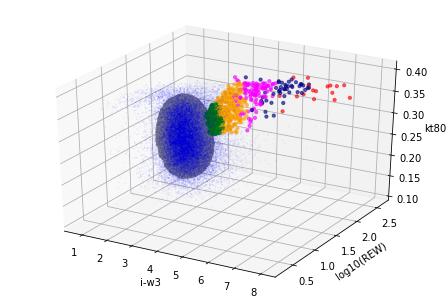

In [110]:
fig =plt.figure()
ax = Axes3D(fig)

color_code = []
bin_label_cone = bin_label[bin_label>1]
X_cone=X[bin_label>1]
for i in range(len(bin_label_cone)):
    color_code.append(colors[int(bin_label_cone[i])-2])

X_tip = X[tip_label==1]
ax.scatter(X[:,0], X[:,1], X[:,2] ,alpha=0.1, s=0.1, c='blue')

ax.scatter(X_tip[:,0], X_tip[:,1], X_tip[:,2], alpha=0.6, c='gray')
#         color_code.append(color(bin_label_cone[i]/nBin))
ax.scatter(X_cone[:,0], X_cone[:,1], X_cone[:,2], alpha=0.6, c=color_code, s=10)
ERQ0_center = np.median(ERQ0, axis=0)
MainCenter0 = np.median(X, axis=0)
#     ax.scatter(ERQ0_center[0], ERQ0_center[1], ERQ0_center[2], s=100, marker='x', c='black' )
#     ax.scatter(MainCenter0[0] , MainCenter0[1],  MainCenter0[2], s=100, marker='x', c='black' )
ax.set_xlabel('i-w3')
ax.set_ylabel('log10(REW)')
ax.set_zlabel('kt80')
#     ax.set_title('$\Omega=%.2f^{\circ}$, r=%.2f, $\hat{u}$=[%.2f, %.2f, %.2f]' 
#                 %(np.rad2deg(opening_angle), enclosing_ratio, cone_vec_3d[cone_direction,0],\
#                   cone_vec_3d[cone_direction,1],\
#                   cone_vec_3d[cone_direction,2]))
plt.savefig('3d-cone-kde/3d-bin-r-%.2f-dir-%d.png' 
            %(enclosing_ratio, cone_direction), fromat='png',\
           bbox_inches='tight', dpi=200)
plt.show()

0


IndexError: list index out of range

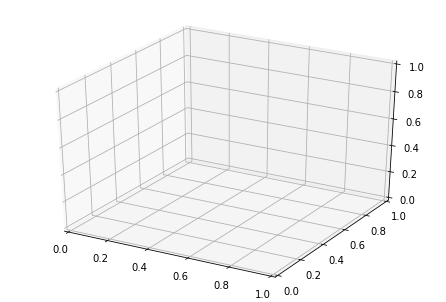

In [71]:
#          #########################Med-Spec####################################
#     nBins = len(bin_pop)
#     for b in range(len(bin_pop)):
#         print('enc-r:', enclosing_ratio, 'cone', cone_direction, 
#             'bin:', b, '#', bin_pop[b])
#         if(bin_pop[b]>5):
#             sp = np.zeros([int(bin_pop[b]), nw])
#             k=-1
#             for i in tqdm(range(nqsos)):
#                 if(bin_label[i]==b+1):
#                     k+=1
#                 # Retrieve the spectra:
#                     file = '/media/reza/My Passport/erq/fred/sdss/%d/spec-%d-%d-%04d.fits' % (plate[i], plate[i],mjd[i],fiberid[i])
#                     spec = erqMedSpec.readDR10spec(file)
#                     wave = spec['wl']
#                     wz = wave/(z_dr12[i]+1)
#                     flux = spec['flux']
#                     mask = (wz > 1680.0) & (wz < 1730.0)
#                     fnorm = np.median(flux[mask])
#                     fluxn = flux/fnorm
#                 # interpolate the rest-frame spectrum onto the standard grid
#                     f = interpolate.interp1d(wz,fluxn,bounds_error=False,fill_value=float('nan'))
#                     sp[k] = f(wgrid)
#                 # calculate the median spectrum

#             med1 = np.nanmedian(sp,axis=0)
#             np.savetxt( '3d-cone-kde/kde-medspec-r-%.2f-bin-%d-cone-%d.txt' 
#             %(enclosing_ratio, b, cone_direction), med1)

In [17]:
s=0
for i in range(nBin):
    ERQ_b = X[((bin_label==i+1) & (iW3_0>=4.6) &(rew_0>=2))]
    b = X[((bin_label==i+1))]
    s+=len(ERQ_b)
    if(len(ERQ_b)>0): 
        print('bin:',i)
        print('#ERQ', len(ERQ_b))
        print('min:', np.min(ERQ_b, axis=0))
        print('max:', np.max(ERQ_b, axis=0))
        print('median:', np.median(ERQ_b, axis=0))
        print('#all:',len(b))
        print('min:',np.min(b, axis=0))
        print('max:', np.max(b, axis=0))
        print('median:', np.median(b, axis=0))
        print('--------------------------')
print(s)
print(bin_pop)

bin: 3
#ERQ 16
min: [4.63119745 2.00219348 0.32508183]
max: [5.11207277 2.1514015  0.37233219]
median: [4.80913311 2.04951762 0.36172855]
#all: 98
min: [3.38801539 1.57414538 0.276726  ]
max: [5.11207277 2.17499123 0.37242501]
median: [4.59588062 1.95785963 0.35618137]
--------------------------
bin: 4
#ERQ 30
min: [4.63530474 2.07923041 0.29298678]
max: [6.16507973 2.35486513 0.37236882]
median: [5.45417717 2.18863936 0.36062438]
#all: 45
min: [3.7808471  1.65471475 0.29051924]
max: [6.16507973 2.35486513 0.37236882]
median: [5.38817313 2.15742642 0.36062004]
--------------------------
bin: 5
#ERQ 13
min: [5.22272469 2.02937022 0.32855086]
max: [8.01445085 2.6183043  0.37228798]
median: [6.58095257 2.40822839 0.35968205]
#all: 17
min: [5.22272469 1.78628841 0.32855086]
max: [8.01445085 2.6183043  0.37235414]
median: [6.44965539 2.34192854 0.36073155]
--------------------------
59
[565. 304. 243.  98.  45.  17.]


In [14]:
# bin_label, bin_pop, tip_label, MedianBins, rhoBin \
#          = nSphere_bin(X_sc,  ERQ, nBin, bw, bin_ratio, opening_angle, cone_vec_3d[0])
print('tip...')
tip_pop = int(sum(tip_label))
print(tip_pop)
sp = np.zeros([tip_pop, nw])
k=-1
for i in tqdm(range(nqsos)):
    if(tip_label[i]==1):
        k+=1
    # Retrieve the spectra:
        file = '/media/reza/My Passport/erq/fred/sdss/%d/spec-%d-%d-%04d.fits' % (plate[i], plate[i],mjd[i],fiberid[i])
        spec = erqMedSpec.readDR10spec(file)
        wave = spec['wl']
        wz = wave/(z_dr12[i]+1)
        flux = spec['flux']
        mask = (wz > 1680.0) & (wz < 1730.0)
        fnorm = np.median(flux[mask])
        fluxn = flux/fnorm
    # interpolate the rest-frame spectrum onto the standard grid
        f = interpolate.interp1d(wz,fluxn,bounds_error=False,fill_value=float('nan'))
        sp[k] = f(wgrid)
    # calculate the median spectrum

  0%|          | 0/30592 [00:00<?, ?it/s]

tip...
19652


100%|██████████| 30592/30592 [49:27<00:00, 10.31it/s]  


In [15]:
med1 = np.nanmedian(sp,axis=0)
np.savetxt('3d-cone-kde/medspec-tip1.txt',med1) 

/home/reza/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:995: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


bin: 5 1000 to 1980
bin: 4 1000 to 1980
bin: 3 1000 to 1980
bin: 2 1000 to 1980
bin: 1 1000 to 1980


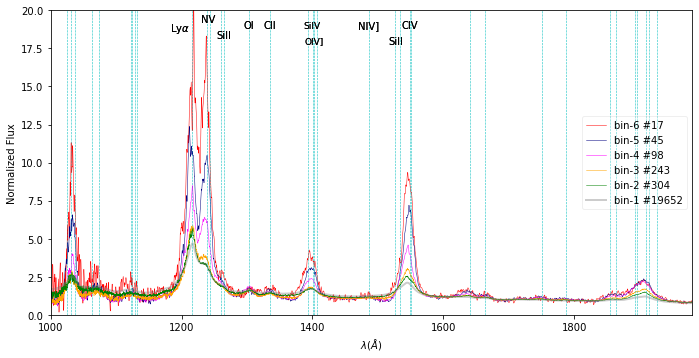

bin: 5 1150 to 1980
bin: 4 1150 to 1980
bin: 3 1150 to 1980
bin: 2 1150 to 1980
bin: 1 1150 to 1980


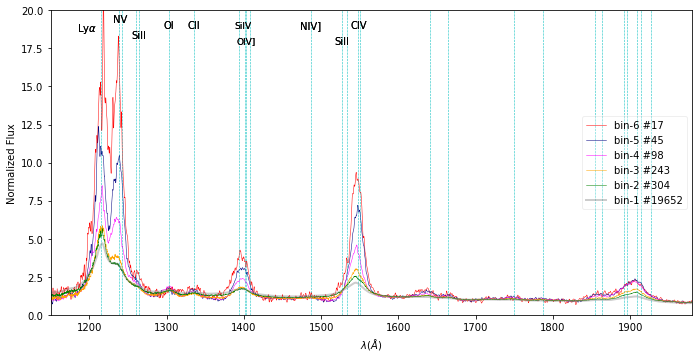

bin: 5 1150 to 2850
bin: 4 1150 to 2850
bin: 3 1150 to 2850
bin: 2 1150 to 2850
bin: 1 1150 to 2850


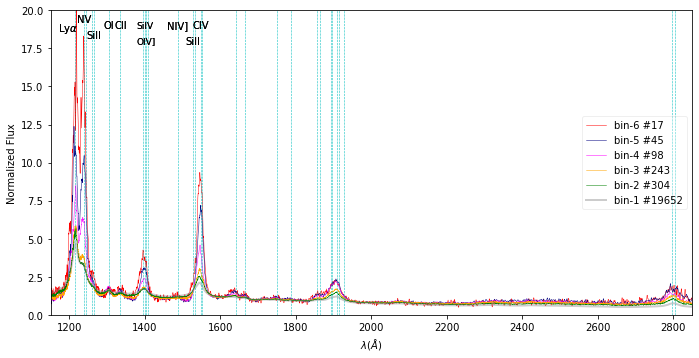

bin: 5 1150 to 1700
bin: 4 1150 to 1700
bin: 3 1150 to 1700
bin: 2 1150 to 1700
bin: 1 1150 to 1700


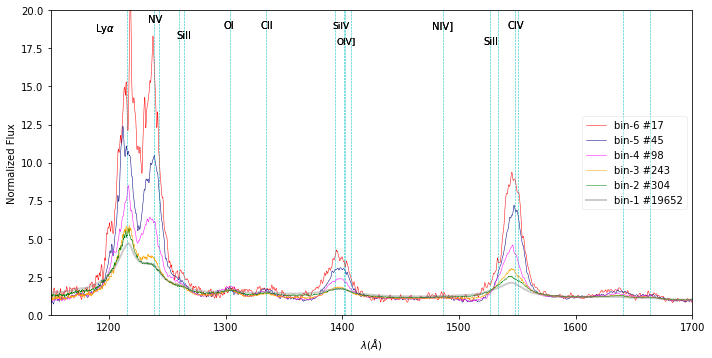

In [111]:
#  plotting
from scipy import interpolate
# import pyfits
from numpy import *
import math
import scipy.ndimage
from scipy import interpolate
from numpy import nanmean
from numpy import nanmedian
from readSDSSspectrafast import *
from scipy import ndimage
from line_db import line_db
import os
#  nqsos is the total number of quasars in the catalog.
# zdr12 is the redshift from the DR12 catalog. You might use something else.
# zp1 is z+1

# This loop goes through the quasar selection only to determine the total number that will go into the median
# nqsos = len(z_dr12)
nqsos = len(z_dr12)

# This 2D array will hold all the spectra used for the median below
# while(wedge<360):


# tip_label=np.loadtxt('3d-cone-kde/tip_label.txt')
tip_pop = int(sum(tip_label))
# Enclosing_ratio=[0.95, 0.90, 0.85, 0.80, 0.75, 0.70]
# Enclosing_ratio=[0.75]
# kk=-1
# for enclosing_ratio in [0.7]: 
# for enclosing_ratio in Enclosing_ratio: 
#     kk+=1
# enclosing_ratio=0.75
# opening_angle, cone_dir = opening_angle_finder(ERQ, MainCenter, enclosing_ratio, 10000)
for cone_direction in range(1):

    bin_label=np.loadtxt( '3d-cone-kde/bin_label-r-%.2f-cone-dir-%d.txt' %(enclosing_ratio,cone_direction))
    bin_pop=np.loadtxt( '3d-cone-kde/bin_pop-r-%.2f-cone-dir-%d.txt' %(enclosing_ratio,cone_direction))

    
    ymax=20
    ymin=-0.05*ymax
    fs=10
    fs1=9

    y_median = 0.83*ymax
    med_step=1
    legend_loc=7
#         if(dir==1 and enclosing_ratio>0.75): 
#             ymax=18.0; ymin=0.01*ymax; fs=10; fs1=9; x_median=1280; 
#             y_median = 0.83*ymax; med_step=0.7; legend_loc=7
#         if(dir==1 and enclosing_ratio<=0.75): 
#             ymax=18.5; ymin=0.01*ymax; fs=10; 
#             fs1=9; x_median=1280; y_median = 0.83*ymax; med_step=0.7; legend_loc=1
#         if(dir==2 and enclosing_ratio>=0.9): 
#             ymax=16; ymin=0.01*ymax; fs=10; fs1=9; 
#             x_median=1280; y_median = 0.83*ymax; med_step=0.7; legend_loc=7
#         if(dir==2 and enclosing_ratio<0.9): 
#             ymax=15; ymin=0.01*ymax; fs=10; fs1=9; 
#             x_median=1280; y_median = 0.83*ymax; med_step=0.7; legend_loc=7
#         if(dir==3 and enclosing_ratio>=0.9): 
#             ymax=9; ymin=0.01*ymax; fs=10; fs1=9; 
#             x_median=1280; y_median = 0.83*ymax; med_step=0.7; legend_loc=71/27,
#         if(dir==3 and enclosing_ratio<0.9): 
#             ymax=11; ymin=0.01*ymax; fs=10; fs1=9; 
#             x_median=1280; y_median = 0.83*ymax; med_step=0.7; legend_loc=7
#         if(dir==4 or dir==5): 
#             ymax=5.5; ymin=0.05*ymax; fs=10; fs1=9; 
#             x_median=1280; y_median = 0.83*ymax; med_step=0.7; legend_loc=7

    for ii in range(0,4):

        if(ii==0): lambda_min = 1000; lambda_max = 1980
        if(ii==1): lambda_min = 1150; lambda_max = 1980
        if(ii==2): lambda_min = 1150; lambda_max = 2850
        if(ii==3): lambda_min = 1150; lambda_max = 1700
        fig = plt.figure(figsize=(11.5,5.6))
        line_db(ymax, fs, fs1, lambda_max)

        plt.xlim(lambda_min,lambda_max)
        plt.ylim(ymin, ymax)
        # plt.axes().set_aspect('equal')
        x_median=lambda_min+100


#         for b in range(len(bin_pop)-1,-1,-1):
        for b in range(len(bin_pop)-1,0 , -1):

            if(bin_pop[b]>5):   
                print('bin:', b, lambda_min, 'to', lambda_max)
                med1=loadtxt('3d-cone-kde/kde-medspec-r-%.2f-bin-%d-cone-%d.txt' %(enclosing_ratio, b, cone_direction))
                plt.ylabel('Normalized Flux')
                plt.xlabel(r'$\lambda  (\AA)$')
                w3_bin=[]
                imw3_bin=[]
                REW_bin=[]
                fwhm_bin=[]
                kt80_bin=[]
                frat_bin=[]
                iz_bin=[]
                Lum_bin=[]

                for i in range(nqsos):
                    if(bin_label[i]==b+1):
                        w3_bin.append(W3_0[i]) 
                        imw3_bin.append(iW3_0[i])
                        REW_bin.append(int(10**rew_0[i]))
                        fwhm_bin.append(fwhm_0[i])
                        kt80_bin.append(kt80_0[i])
                        frat_bin.append(frat_0[i])
                        iz_bin.append(iz_0[i])
                        Lum_bin.append(Lum_0[i])
                if(bin_pop[b]<100):
                    sm_med1 = ndimage.filters.gaussian_filter1d(med1,2.0)
                else:
                    sm_med1=med1

                # masking for plot ranges
                ind = (wgrid>lambda_min) & (wgrid<lambda_max)

                plt.plot(wgrid[ind],  sm_med1[ind], lw = .5, c=colors[b-1], 
                         label='bin-%d #%d' %(b+1, bin_pop[b]))
#                 plt.text(x_median, y_median -(b+1)*med_step,
#                          'bin%d  #%d,    i-w3=%.1f,   REW=%d,   FWHM=%d,   kt80=%.2f,   Nv/Civ=%.2f,   i-z=%.1f' 
#                          %(b+1, bin_pop[b], np.median(imw3_bin),  
#                             np.median(REW_bin), np.median(fwhm_bin),  
#                             np.median(kt80_bin), np.median(frat_bin), 
#                             np.median(iz_bin)), 
#                          ha='left', va='center', color=c[b], fontsize=10)

        tip_spec = np.loadtxt('3d-cone-kde/medspec-tip1.txt')            
        plt.plot(wgrid[ind],  tip_spec[ind], lw = 2,
                 label = 'bin-1 #%d' %(tip_pop), c = 'gray', alpha=0.4)
#         plt.text(x_median, y_median -(b+1)*med_step,
#                          'bin%d  #%d,    i-w3=%.1f,   REW=%d,   FWHM=%d,   kt80=%.2f,   Nv/Civ=%.2f,   i-z=%.1f' 
#                          %(b+1, bin_pop[b], np.median(imw3_bin),  
#                             np.median(REW_bin), np.median(fwhm_bin),  
#                             np.median(kt80_bin), np.median(frat_bin), 
#                             np.median(iz_bin)), 
#                          ha='left', va='center', color=c[b], fontsize=10)
        plt.legend(fancybox=True, framealpha=0.3, loc=legend_loc)
        line_db(ymax, fs, fs1, lambda_max)
#         plt.title(r'$\Omega=%.2f^{\circ}$, r=%.2f, $\hat{u}$=[%.2f, %.2f, %.2f]' 
#                 %(np.rad2deg(opening_angle), 
#                   enclosing_ratio, cone_vec_3d[cone_direction,0],
#                   cone_vec_3d[cone_direction,1],
#                   cone_vec_3d[cone_direction,2]))
        fig_path = '3d-cone-kde/med-spec/3d-r-%d-dir-%d-li-%d-lf-%d.png' %(enclosing_ratio*100, cone_direction, lambda_min,
                                                                    lambda_max)
        plt.savefig(fig_path, format='png', dpi=200,  bbox_inches='tight')
        # os.system('evince '+ fig_path)
        # plt.savefig('/home/reza/erq/kde/bw/enc-r-%.2f/test.pdf' %(enclosing_ratio),format='pdf',  bbox_inches='tight')
        plt.show()
        plt.clf()
        plt.cla()
        plt.close()



In [102]:
colors

['green', 'red', 'magenta', 'navy', 'cyan']

In [40]:


imw3_bin_med =[]
REW_bin_med = []
fwhm_bin_med = []
kt80_bin_med = []
frat_bin_med = []
iz_bin_med = []
Lum_bin_med = []
Bin=[]
BinPop=[]
# tip 
mask = tip_label
BinPop.append(sum(mask))
Bin.append("central")
imw3_bin_med.append("{0:.2f}".format(np.median(iW3_0[mask==True])))
REW_bin_med.append("{0:.0f}".format(np.median(10**(rew_0[mask==True]))))
fwhm_bin_med.append("{0:.0f}".format(np.median(fwhm_0[mask==True])))
kt80_bin_med.append("{0:.2f}".format(np.median(kt80_0[mask==True])))
frat_bin_med.append("{0:.2f}".format(np.median(frat_0[mask==True])))
iz_bin_med.append("{0:.2f}".format(np.median(iz_0[mask==True])))
Lum_bin_med.append("{0:.2f}".format(np.median(Lum_0[mask==True])))

for b in range(len(bin_pop)):
    mask = (bin_label==b+1)
    BinPop.append(sum(mask))
    Bin.append("{0:.0f}".format(b+1))
    imw3_bin_med.append("{0:.2f}".format(np.median(iW3_0[mask==True])))
    REW_bin_med.append("{0:.0f}".format(np.median(10**(rew_0[mask==True]))))
    fwhm_bin_med.append("{0:.0f}".format(np.median(fwhm_0[mask==True])))
    kt80_bin_med.append("{0:.2f}".format(np.median(kt80_0[mask==True])))
    frat_bin_med.append("{0:.2f}".format(np.median(frat_0[mask==True])))
    iz_bin_med.append("{0:.2f}".format(np.median(iz_0[mask==True])))
    Lum_bin_med.append("{0:.2f}".format(np.median(Lum_0[mask==True])))

tabProperties = Table([Bin,BinPop, imw3_bin_med, REW_bin_med, fwhm_bin_med, kt80_bin_med, frat_bin_med, iz_bin_med, Lum_bin_med],
                      names=('Bin','nBin', 'iw3', 'rew', 'fwhm', 'kt80', 'frat', 'iz', 'Lum'))
if os.path.exists('3d-Properties.fits'):
    os.system('rm 3d-Properties.fits')
tabProperties.write('3d-Properties.fits' , format='fits')

In [21]:
bin_label

array([0., 0., 0., ..., 0., 0., 0.])

In [24]:
mask

array([False, False, False, ..., False, False, False])

In [25]:
dir

<function dir>

In [105]:
for b in range(len(bin_pop), 1, -1):
    print(b)


6
5
4
3
2
